In the context of data types, "ordered" data refers to ordinal data.
Ordinal data is a type of categorical data with an order (or rank).
The order of these values is significant and typically represents some sort of hierarchy.
For example, ratings data (like "poor", "average", "good", "excellent") is ordinal
because there is a clear order to the categories.

| Feature         | Description                                                  | Type
| ---             | ---                                                          | ---                                    
| **age**         | Age                                                          | Real
| **sex**         | Sex                                                          | Binary
| **cp**          | Chest pain type (4 values)                                   | Nominal
| **trestbps**    | Resting blood age                                            | Real
| **chol**        | Serum cholesterol (in mg/dl)                                 | Real
| **fbs**         | Fasting blood sugar > 120 mg/dl                              | Binary
| **restecg**     | Resting electrocardiographic results (values 0,1,2)          | Nominal
| **thalach**     | Maximum heart rate achieved                                  | Real
| **exang**       | Exercise induced angina                                      | Binary
| **oldpeak**     | Oldpeak = ST depression induced by exercise relative to rest | Real
| **slope**       | The slope of the peak exercise ST segment                    | Ordered
| **ca**          | Number of major vessels (0-3) colored by flouroscopy         | Real
| **thal**        | Thal: 3 = normal; 6 = fixed defect; 7 = reversable defect    | Nominal
| **target**      | 1 = no disease; 2 = presence of disease                      | 

In [17]:
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

detail = {"age": "Age", "sex": "Sex", "cp": "Chest Pain Type", "trestbps": "Resting Blood Pressure",
          "chol": "Serum Cholesterol", "fbs": "Fasting Blood Sugar", "restecg": "Resting ECG",
          "thalach": "Max Heart Rate", "exang": "Exercise Induced Angina", "oldpeak": "Oldpeak",
          "slope": "Slope", "ca": "Number of major vessels", "thal": "Thal", "target": "(0 - no disease, 1 - disease))"}

sns.set_theme(context="paper", font_scale=1.5, style="whitegrid", palette="Set2")

data = pd.read_csv("heart.dat", sep="\\s+", header=None)
data.columns = detail.keys()

numericFeatures = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
categoricalFeatures = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

# Data Pre-Processing


In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Check for missing values
print("Number of missing values:", data.isnull().sum().sum(), "\n")
# Check for duplicates
print("Number of duplicates:", data.duplicated().sum(), "\n")

X = data.iloc[:, :-1]
Y = data.iloc[:, -1]

# print(data.describe())

# print(X[continuousFeatures].head(), "\n")
# Apply scaler only to continuous variables
X[numericFeatures] = StandardScaler().fit_transform(X[numericFeatures])
#X[continuousFeatures] = MinMaxScaler().fit_transform(X[continuousFeatures])

# print(X[continuousFeatures].head(), "\n")

X_oneHot = pd.get_dummies(X, columns=["cp", "restecg", "slope", "thal"])

noFeatures = X_oneHot.shape[1]
print("Number of features: ", noFeatures, "\n")
# print(one_hot_X.head())


Number of missing values: 0 

Number of duplicates: 0 

Number of features:  22 



# Feature Correlation

## Heatmap

Although the heatmap should work better with numeric features, categorical binary ones also are simple enough that a numeric relationship can also apply to its categorical nature.
Features used:
- **numerical** - age, trestbps, chol, thalach, oldpeak, ca
- **categorical** - sex, fbs, exang

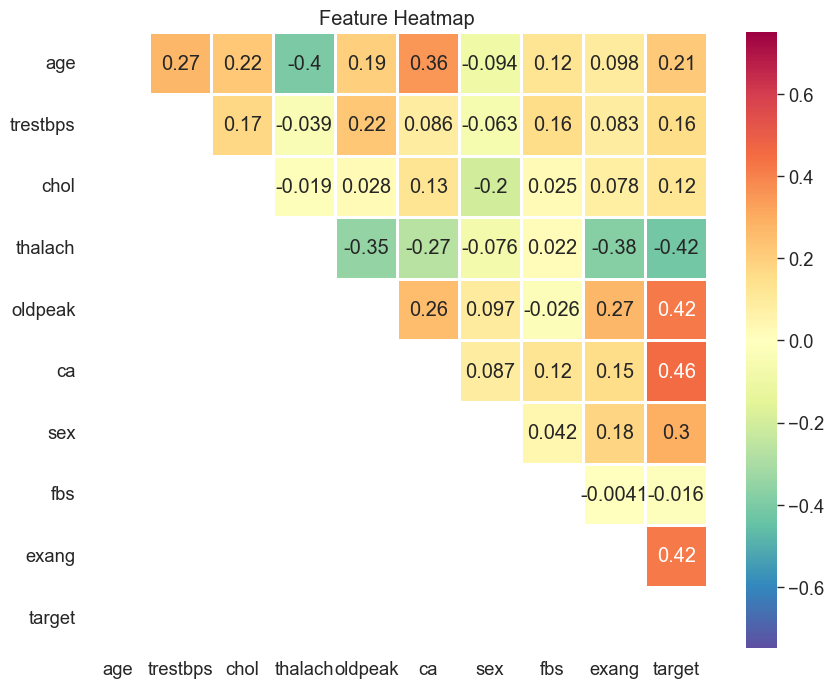

In [19]:
figsize = (10, 8)
vmin = -0.75
vmax = 0.75

X_heatmap = X[numericFeatures + ["sex", "fbs", "exang"]]

dataCorr = pd.concat([X_heatmap, data["target"]], axis=1).corr()

upperHalf_mask = np.tril(np.ones_like(dataCorr, dtype=bool))    # remove bottom left corner

plt.figure(figsize=figsize)
plt.title("Feature Heatmap")
sns.heatmap(dataCorr, annot=True, linewidths=2,
            mask=upperHalf_mask, cmap="Spectral_r", vmin=vmin, vmax=vmax
)
plt.savefig(f"plots/heatmap/heatmap.png")

Features like **fbs**, **chol** and **trestbps** seem uninteresting for target prediction. Before trying the models without them, let's try removing the outliers and see if anything changes.

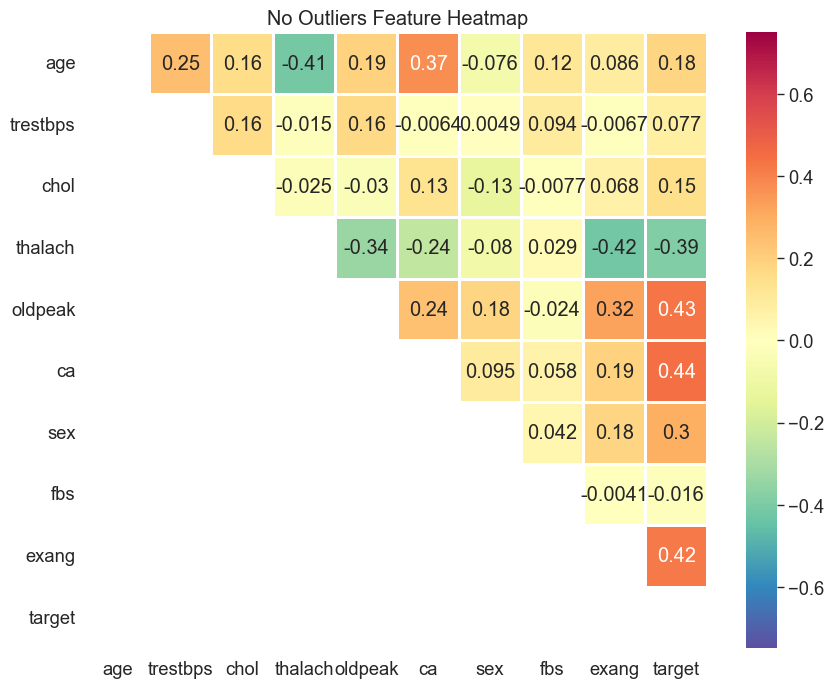

In [20]:
X_heatmap = X[numericFeatures]

Q1 = X_heatmap.quantile(0.25)
Q3 = X_heatmap.quantile(0.75)
IQR = Q3 - Q1

# Removing outliers 1.5 * IQR below and above the Q1 and Q3, respectively
X_heatmap_noOut =  X_heatmap[~((X_heatmap < (Q1 - 1.5 * IQR)) | (X_heatmap > (Q3 + 1.5 * IQR))).any(axis=1)]
X_heatmap_noOut = pd.concat([X_heatmap_noOut, X[["sex", "fbs", "exang"]]], axis=1)

dataCorr_noOut = pd.concat([X_heatmap_noOut, data["target"]], axis=1).corr()

upperHalf_mask = np.tril(np.ones_like(dataCorr_noOut, dtype=bool))

plt.figure(figsize=figsize)
plt.title("No Outliers Feature Heatmap")
sns.heatmap(dataCorr_noOut, annot=True, linewidths=2,
            mask=upperHalf_mask, cmap="Spectral_r", vmin=vmin, vmax=vmax
)
plt.savefig(f"plots/heatmap/heatmap_noOutliers.png")


Plotting the difference between heatmaps...

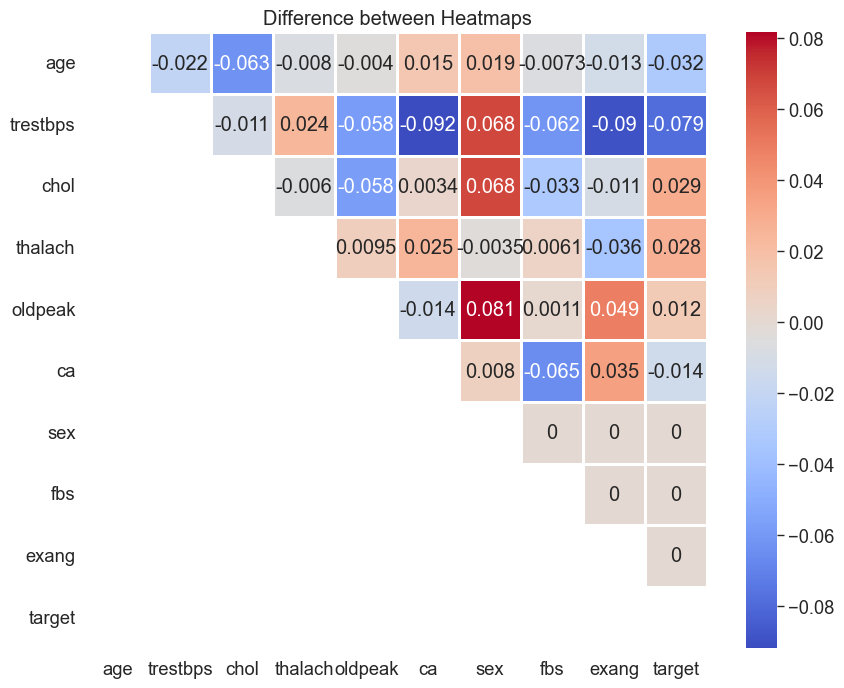

In [21]:
# Calculate the difference between the two correlation matrices
heatmap_diff = dataCorr_noOut - dataCorr

# Plot the difference heatmap

plt.figure(figsize=figsize)
plt.title("Difference between Heatmaps")
sns.heatmap(heatmap_diff, annot=True, linewidths=2, mask=upperHalf_mask, cmap="coolwarm")
plt.savefig(f"plots/heatmap/heatmap_diff.png")


The feature **trestbps** was the most affected by outlier removal, as the correlation decrease 0.79 from 0.16. This could say the outliers were relevant cases to consider, but we can look at its density distribution and boxplot to assess that it provides little information for the classification, as the distributions for disease and no disease are pratically overlapping.  

A slighter version of the same phenomenon happens for **chol**.  

The categorical feature **fbs** also appears to have little effect on separating the two classes, as the normalized bar plot shows the same proportions between target = 2 (diease) and target = 1 (no disease) for both **fbs** classes.  

It should be relevant to try out the models without these 3 features.

Also, removing features like **age** for Naive Bayes could in theory provide better results, as it is not strongly correlate with the target and but correlates a bit with many other features. 


## Principal Component Analysis

[PCA Explanation](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)  

GitHub Copilot: Advantages of using PCA for dimensionality reduction:

1. **Removes Correlated Features**: In the real world, features are often correlated. PCA allows you to identify the most important features of your dataset, reducing it to a smaller set of uncorrelated features, known as principal components.

2. **Improves Algorithm Performance**: With fewer features, the performance of a machine learning algorithm can improve. It can also reduce overfitting.

3. **Reduces Overfitting**: By reducing the dimensionality of your feature space, you're less likely to overfit your model.

4. **Improves Visualization**: It's hard to visualize high dimensional data. PCA transforms a high dimensional data set to 2 or 3 dimensions so we can plot and understand data better.

Disadvantages of using PCA:

1. **Independent variables become less interpretable**: After implementing PCA, your original features will turn into Principal Components. Principal Components are the linear combination of your original features. Principal Components are not as readable and interpretable as original features.

2. **Data standardization is must before PCA**: You must standardize your data before implementing PCA, otherwise PCA will not be able to find the optimal Principal Components.

3. **Information Loss**: Although principal components attempt to retain as much information as possible, some information is lost when reducing dimensions, which can potentially degrade the performance of your machine learning model.

4. **Doesn't handle non-linear features well**: PCA assumes that the principal components are a linear combination of the original features. If this assumption is not true, PCA may not give you the results you're looking for.

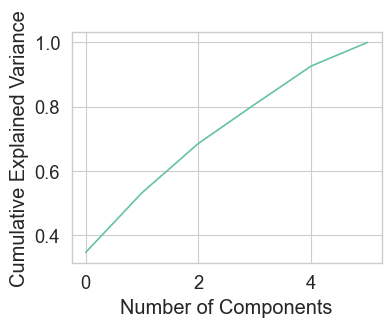

In [22]:
from sklearn.decomposition import PCA

X_pca = X[numericFeatures]

pca = PCA(n_components=len(X_pca.columns))
pca_result = pca.fit_transform(X_pca)

explained_variance = pca.explained_variance_ratio_

# plot no of components vs cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(4, 3))
plt.plot(explained_variance, )
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()



By plotting the *Number of Components* against the *Cumulative Explained Variation*, we can see that 5 principal components are useful to explain 100% of the variance, the same number of numeric features. PCA won't provide the benefit of reducing dimensionality of the dataset.

Copilot:

That said, PCA can still be useful in this case for other reasons:

1. **Feature Independence**: The PCs are linearly independent of each other, which can help with certain types of models that assume feature independence (like linear regression).

2. **Interpretability**: PCs can sometimes be interpreted in terms of the original features, which can provide insights into the structure of your data.

3. **Noise Reduction**: PCA can help to reduce noise in your data by focusing on the directions of maximum variance and ignoring smaller, potentially noisy fluctuations.

In [23]:
from mpl_toolkits.mplot3d import Axes3D

nPCs = 5
pca = PCA(n_components=nPCs)
pca_result = pca.fit_transform(X_pca)

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: {explained_variance}")
# print(pca.components_)  # feature weight for each pc

# Convert it back to a DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=["PC" + str(i + 1) for i in range(nPCs)])


X_oneHot_PCAed = pd.concat([pca_df, X_oneHot.drop(X_oneHot.columns, axis=1)], axis=1)

# print(X_oneHot_PCAed.columns)

Explained Variance: [0.3447508  0.18632201 0.15375034 0.12203783 0.11928476]


# Naive Bayes

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# Create empty lists to store the evaluation metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []


for random_state in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)
    # Perform further analysis or model training with the current split
    # Create a Naive Bayes classifier
    model = GaussianNB()

    # Train the model using the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    # pos_label referes to the HD presence class (the positive class)
    pos_label = 1
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=pos_label)
    recall = recall_score(y_test, y_pred, pos_label=pos_label)
    f1 = f1_score(y_test, y_pred, pos_label=pos_label)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Append the evaluation metrics to the respective lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Print the evaluation metrics for the current iteration
    # print("Confusion Matrix:")
    # print(pd.DataFrame(cm, columns=["Predicted HD Absence", "Predicted HD Presence"], index=["Actual HD Absence", "Actual HD Presence"]))
    # print()


# Create a DataFrame to store the evaluation metrics for each iteration
metrics_df = pd.DataFrame({
    "Iteration": range(1, 6),
    "Accuracy": accuracy_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "F1 Score": f1_list
})

# Print the metrics table
print("Metrics Table:")
print(metrics_df)


Metrics Table:
   Iteration  Accuracy  Precision    Recall  F1 Score
0          1  0.740741   0.766667  0.766667  0.766667
1          2  0.870370   0.875000  0.903226  0.888889
2          3  0.796296   0.888889  0.750000  0.813559
3          4  0.759259   0.800000  0.774194  0.786885
4          5  0.740741   0.687500  0.846154  0.758621


# Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

# Create empty lists to store the evaluation metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

print("Accuracies")
for random_state in range(5):
    # Dividir os dados em training data & Test data, de forma aleatória
    X_train, X_test, Y_train, Y_test = train_test_split(X_oneHot, Y, test_size=0.2, random_state=random_state)

    #Logistic Regression
    model = LogisticRegression()

    #Treinar o modelo Logistic Regression com a Training Data
    model.fit(X_train, Y_train)

    # Avaliação do Modelo

    #Accuracy on training data
    X_train_prediction=model.predict(X_train)
    training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
    print(f"Training Data: {training_data_accuracy:.3f}", end='\t')

    #Accuracy on test data
    X_test_prediction=model.predict(X_test)
    test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
    print(f"Test Data: {test_data_accuracy:.3f}")

    # Calculate evaluation metrics
    # pos_label referes to the HD presence class (the positive class)
    pos_label = 1
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=pos_label)
    recall = recall_score(y_test, y_pred, pos_label=pos_label)
    f1 = f1_score(y_test, y_pred, pos_label=pos_label)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Append the evaluation metrics to the respective lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)


# Sistema

# input_data = (52,1,0,125,212,0,1,168,0,1,2,2,3) # Estes valores são os da primeira linha do heart.csv

# input_data_as_numpy_array = np.asarray(input_data) #Converter a input data num array
# input_data_reshaped = input_data_as_numpy_array.reshape(1,-1) #Reshape do array em uma linha em quantas colunas necessária para preservar o número original de elementos

# prediction = model.predict(input_data_reshaped)
# print(prediction)

# if(prediction[0]==0):
#     print('The patient does not have a Heart Disease')
# else:
#     print('The patient has a Heart Disease')


Accuracies


Training Data: 0.889	Test Data: 0.796
Training Data: 0.870	Test Data: 0.852
Training Data: 0.903	Test Data: 0.815
Training Data: 0.907	Test Data: 0.759
Training Data: 0.898	Test Data: 0.704


# Decision Trees

In [26]:
from sklearn.tree import DecisionTreeClassifier


# Create an instance of the DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_oneHot, Y, test_size=0.2, random_state=0)

# Train the decision tree classifier
dt_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.8148148148148148
Precision: 0.8333333333333334
Recall: 0.8333333333333334
F1 Score: 0.8333333333333334
